<header><h1>Clustering, PCA and Analysis on Monthly Balance Table</h1></header>
<h1><strong>Team: </strong> Chimdia Kabuo, Pauline Korukundo, Anushka Bhat</h1>
<h1><strong>Supervisor: </strong> Alessandro Selvitella</h1>

Using unsupervised learning we can uncover structure in the data and interesting factors that can segment the 3RFCU customers into meaningful groups. 

This work looks at the Customer to Account Table, the Monthly Balance and the KLI. It considers both the Savings and Checkings Customers and also analyses them independently. It also reduces the Key Lifestyle Indicators from 122 to 11 factors.

<h3>Install Packages</h3>

<span>Run Once!</span>

In [1]:
# Save current warning behavior
old_warning <- getOption("warn")

# Temporarily suppress warnings
options(warn = -1)

required_packages <- c("reshape2", "car", "FactoMineR", "factoextra", "psych", "patchwork")

# Check if each package is already installed, if not, install it
for (package in required_packages) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }
}

# Restore original warning behavior
options(warn = old_warning)

<h3>Load Packages</h3>

In [33]:
library(lubridate)
library(tidyverse)
library(ggplot2)
library(reshape2)

library(rlang)
library(car)
library(dplyr)
library(cluster)
library(stats)
library(FactoMineR)
library(factoextra)
library(psych)
library(zoo)
library(ggpubr)
library(patchwork)

In [34]:
# Set global display option to avoid scientific notation
options(scipen = 999)
set.seed(100) #To get consistent results

<h3>Function | Get Eligible Population | </h3>

In [35]:

#### ----------------------------------------------------------------- Start Functions ****************************************************

## remove leading/trailing white space, convert blank cells to NA, convert POSIX object to Date, and convert from character to numeric where appropriate
Clean_Data_fx <- function(df1){
  ## Convert blanks to NA. Need to do this outside of dtplyr to recover type
  df1 <- map_df(df1, function(x){
    # Everything will be convert to character type. Capture the type to later convert back
    Type_use <- switch(match(typeof(x), c("logical", "integer", "double", "character")),
                       as.logical,
                       as.integer,
                       as.double,
                       as.character)
    
    Convert <- map_lgl(class(x), function(y){
      y %in% c("POSIXct", "POSIXt", "Date")
    })
    
    if(any(Convert)){
      return(as.Date(x))
      
    }else if(typeof(x) == "character"){
      return(tryCatch(type.convert(Type_use(gsub("^$", NA, trimws(x))), as.is = TRUE), error = function(e) x))
      
    }else{
      return(tryCatch(type.convert(Type_use(gsub("^$", NA, x)), as.is = TRUE), error = function(e) x))
    }
    
  })
  
  df1 <- df1 %>% mutate(across(where(is.factor), ~ as.character(.x)))
  
  return(df1)
  
}


#### ----------------------------------------------------------------- End Functions ****************************************************


###--------------------------------- Start Get Eligible Population ----------------------------------------------

## 3 months from end of August. Used to determine eligible members and checking and savings accounts
Startdate <- as.Date("2023-06-01", origin = "1970-01-01")


## Start with customer data to determine elgibility then look at account data
df_Cust <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/Customer_Table.rds')

## active member from at least June 1st 2023 and is currently active the customer type is "Personal" and the member is at least 18 years old
ID_use <- df_Cust %>%
  Clean_Data_fx(.) %>%          ## this is a self-written function to clean the data
  filter(datejoined < Startdate,
         isactive == "Yes",
         type == "Personal",
         age >= 18) %>%
  pull(id)
  

## read in customer to account table
df_CtA <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/CustomerToAccount_Table.rds')

## member needs to have an active checking or savings account that was opened before June 1st. 
# Doesn't matter if they are the primary on the account. Use the customer to account table because the account table will only have primary member
df_Population <- df_CtA %>%
  filter(application %in% c("CH", "SV")) %>%
  Clean_Data_fx(.) %>%                          ## this is a self-written function to clean the data
  filter(customerid %in% ID_use,
         startdatetime < Startdate,
         isactive == "Yes") %>%
  mutate(accountid = as.character(accountid)) ## make account id a string instead of a number

## read in account table. Need the  product market field
df_Acct <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/Account_Table.rds')

## last step is to check whether any of the checking or saving accounts are "Consumer". If not then drop 
df_Population  <- df_Acct %>%
  select(number, productmarket, productname) %>%
  left_join(df_Population, ., by = c("accountid" = "number")) %>%
  filter(is.na(productmarket == "Consumer") | productmarket == "Consumer",  ## some productmarket labels are missing which would count as "Consumer"
         productname != "Business Money Market") %>%                        #  except "Business Money Market"                     
  distinct(customerid)   ## only want unique customer id. 
  
  ## Need Secondary_ID to identify other memberships of the member. We will want to use that data for the member
df_Population <- df_Cust %>%
  select(customerid = id, Secondary_ID) %>%
  filter(customerid %in% df_Population$customerid) %>%
  mutate(Secondary_ID = ifelse(is.na(Secondary_ID), customerid, Secondary_ID)) ## assigned customerid when secondary is missing to filter when merging

# saveRDS(df_Population, file.path("/anvil/projects/tdm//corporate/3rivers-membership/projects/x-pkorukundo/Eligible_Members.rds"))
###--------------------------------- End Get Eligible Population ----------------------------------------------               

In [37]:
# Reading Eligible population into a csv file
df_Population <- read.csv("Eligible_Members.csv")

# read in the KLI table
df_KLI <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/KeyLifestyleIndicator_Table.rds')

# Joining population of interest to Customer to Account table
Cust_Acct <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/CustomerToAccount_Table.rds')

# Read in Monthly Balance Table
Month_Bal <- readRDS("/anvil/projects/tdm//corporate/3rivers-membership/data/MonthlyBalance_Table.rds")

Joining the Customer to Accounts table to the Monthly Balance table. And the result to the Customer table. The eligible population is then selected

In [38]:
Acct_KLI <- inner_join(Cust_Acct, df_KLI, by = c("customerid" = "CustomerID"), relationship = "many-to-many")

In [39]:
dim(Acct_KLI)

[1] 9593408       9

In [7]:
Acct_KLI <- Acct_KLI %>%
    filter(application %in% c("SV", "CH")) %>%
      Clean_Data_fx(.) %>%           ## this is a self-written function to clean the data
      filter(customerid %in% ID_use,
         startdatetime < Startdate,
         isactive == "Yes")

In [8]:
dim(Acct_KLI)

[1] 4293657       9

In [9]:
MTB_short <- Month_Bal %>%
    filter(enddate > as.Date("2022-08-31")) %>%
    group_by(monthyear) %>%
    mutate(baldifference = maxbalance - minbalance) %>%
    arrange(desc(monthyear))

# Replace NAs in end date with currentdate and find period a customer has been a member
MTB_short$enddate <- ifelse(is.na(MTB_short$enddate), Sys.Date(), MTB_short$enddate)
MTB_short$enddate <- format(Sys.Date(), "%Y-%m-%d")
MTB_short$enddate <- as.Date(MTB_short$enddate)
MTB_short$begindate <- as.Date(MTB_short$begindate)
MTB_short <- MTB_short %>%
    mutate(periodamember = (enddate - begindate)/30)

MTB_short$periodamember <- as.numeric(MTB_short$periodamember)
class(MTB_short$periodamember)
print(typeof(MTB_short$enddate))

[1] "numeric"

[1] "double"


In [10]:
Acct_KLI_MTB <- inner_join(Acct_KLI, MTB_short, by = c("accountid" = "accountprimarykey"), relationship = "many-to-many")
Acct_KLI_MTB_Pop <- inner_join(Acct_KLI_MTB, df_Population, by = "customerid")

In [11]:
dim(Acct_KLI_MTB_Pop)
summary(Acct_KLI_MTB_Pop)

[1] 38642224       22

  accountid         application         customerid         enddatetime      
 Length:38642224    Length:38642224    Length:38642224    Min.   :NA        
 Class :character   Class :character   Class :character   1st Qu.:NA        
 Mode  :character   Mode  :character   Mode  :character   Median :NA        
                                                          Mean   :NaN       
                                                          3rd Qu.:NA        
                                                          Max.   :NA        
                                                          NA's   :38642224  
   isactive          isprimary         startdatetime         durationdays     
 Length:38642224    Length:38642224    Min.   :1953-09-30   Min.   : NA       
 Class :character   Class :character   1st Qu.:2008-12-17   1st Qu.: NA       
 Mode  :character   Mode  :character   Median :2017-02-09   Median : NA       
                                       Mean   :2013-06-11   Mean   :

<h1>Descriptive Analysis</h1>

Data Preparation
1. Checking for missing values
2. Null Values and 
3. Dealing with Outliers 
4. Scaling the data

<h2>Extract Variables to Cluster </h2>

Removing the enddate, startdate and duration days. Duration days had alot of missing values, hence its removal. the dates were used to compute the duration the account was active so they were not required anymore. More variables were removed due to the kernel crushing during the clustering 


In [12]:
df <- subset(Acct_KLI_MTB_Pop, select = -c(enddatetime, startdatetime, durationdays, 
                                           begindate, enddate, customerid, Secondary_ID,  
                                           isactive, monthyear, minbalance, X, accountid, 
                                           maxbalance, endmonthbalance, beginmonthbalance))

The sample data used in the clustering contains about 200,000 observations. 

<h4>Check Dimensions of the data</h4>

In [13]:
#Shuffling the dataset by customer ID and selecting first 0.5% 
set.seed(100)
shuffled_df <- df %>% sample_n(size = n(), replace = FALSE)
sampled_df <- shuffled_df %>% slice(1:round(n() * 0.005))
sampled_df_all <- sampled_df

In [14]:
cat("Dimensions", dim(sampled_df), "\n\n")

summary(sampled_df)

Dimensions 193211 7 



 application         isprimary             KLI            averagebalance     
 Length:193211      Length:193211      Length:193211      Min.   :-240322.9  
 Class :character   Class :character   Class :character   1st Qu.:    179.9  
 Mode  :character   Mode  :character   Mode  :character   Median :    833.2  
                                                          Mean   :   6690.7  
                                                          3rd Qu.:   3335.6  
                                                          Max.   :2753896.4  
 numberoftransactions baldifference     periodamember  
 Min.   :   0.00      Min.   :      0   Min.   : 8.90  
 1st Qu.:   2.00      1st Qu.:    100   1st Qu.:11.70  
 Median :  10.00      Median :    914   Median :14.67  
 Mean   :  32.77      Mean   :   3180   Mean   :14.65  
 3rd Qu.:  51.00      3rd Qu.:   2404   3rd Qu.:17.73  
 Max.   :1061.00      Max.   :6500098   Max.   :19.77  

<!-- <h4>Generate a set of boxplots for each variable in the `Custnum` data frame</h4>
<span>The `HH_Number` column is used in the visualization as the id variable</span -->

There are no missing values in the select dataframe, and 8 variables to work with. We go ahead to perform the clustering on these numeric variables. Before that, we select only a small part of the data due to challenges with the hardware when all the data is used.

<span>Check for unique values in all columns of our data</span>

In [15]:
unique_values <- sapply(sampled_df, function(x) length(unique(x)))
unique_values

application            isprimary                  KLI 
                   2                    2                  211 
      averagebalance numberoftransactions        baldifference 
              130574                  349               108798 
       periodamember 
                 228

There are enough unique values in the dataset

Converting categorical variables to factors

In [16]:
#Convert the categorical data to factors
sampled_df$isprimary <- as.factor(sampled_df$isprimary)
levels <- levels(sampled_df$isprimary)

sampled_df$KLI <- as.factor(sampled_df$KLI)
levels <- levels(sampled_df$KLI)

sampled_df$application <- as.factor(sampled_df$application)
levels <- levels(sampled_df$application)

In [17]:
# Retain original row names
original_row_names <- rownames(sampled_df)

#Converting the mixed data into one hot encoding and scaling it.
df_numeric <- model.matrix(~ . - 1, data = sampled_df)

# Standardize numeric variables
df_scaled <- scale(df_numeric)

<h1>Clustering Analysis</h1>

<h3>Compute K-means Clustering Using Elbow Method</h3>

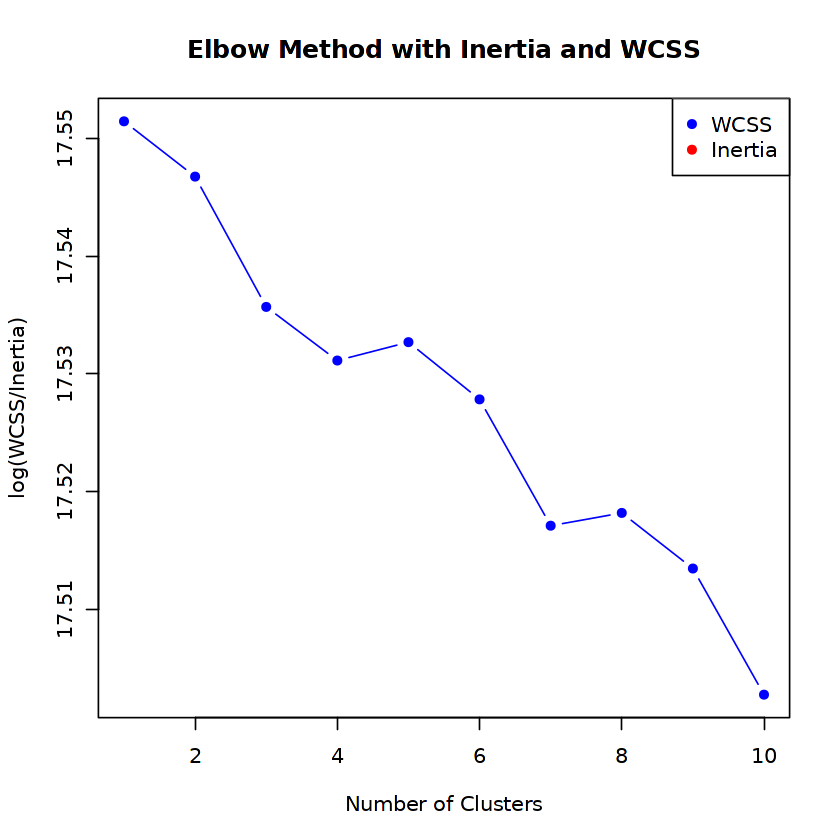

In [18]:
# Create vectors to store the within-cluster sum of squares (WCSS) and inertia for different values of k
wcss <- numeric(10)
inertia <- numeric(10)

# Define a range of values for k
k_range <- 1:10

# Iterate over each value of k
for (k in k_range) {
  # Compute K-means clustering for dataframe with variables dropped
  kmeans_model <- kmeans(df_scaled, centers = k)
  
  # Store the within-cluster sum of squares (WCSS)
  wcss[k] <- kmeans_model$tot.withinss
  
  # Store the inertia
  inertia[k] <- kmeans_model$totss - kmeans_model$tot.withinss
}

# Plot the within-cluster sum of squares (WCSS) and inertia against number of clusters
plot(k_range, log(wcss), type = "b", col = "blue", pch = 16,
     xlab = "Number of Clusters", ylab = "log(WCSS/Inertia)", 
     main = "Elbow Method with Inertia and WCSS")

# Add inertia to the plot
points(k_range, log(inertia), type = "b", col = "red", pch = 16)

# Add legend
legend("topright", legend = c("WCSS", "Inertia"), col = c("blue", "red"), pch = 16)

<h4>Summary</h4>
<p>Using the plot of the within-cluster sum of squares (WCSS), we look for the `elbow point`, where the rate of decrease in WCSS slows down. This would show the point beyond which adding more clusters provides no benefit,

The initial plots show many dips in the wcss plot, making it hard to find an optimal elbow point. When the data points changed, the curve also changed, making the selection of clusters subjective. This might be due to the complexity of the data, thereby suggesting that kmeans might not be the best option to cluster the data. However, due to the presence of factor variables, we use the kmeans to see if we can segment the customers.
    
Therefore from the plot, we select the elbow as 4 but we also investigate other clusters to find the best option.
    

<h4>Generate Cluster Profiles</h4>

<h1>KMEANS CLUSTERING</h1>

The principal components with highest curvature (the elbow) guide on the number of principal components to choose

In [19]:
str(sampled_df)

tibble [193,211 x 7] (S3: tbl_df/tbl/data.frame)
 $ application         : Factor w/ 2 levels "CH","SV": 2 2 2 1 1 1 1 2 2 1 ...
 $ isprimary           : Factor w/ 2 levels "No","Yes": 2 1 2 2 2 2 1 2 1 2 ...
 $ KLI                 : Factor w/ 211 levels "Account in Delinquency",..: 74 111 153 83 152 73 29 49 203 193 ...
 $ averagebalance      : num [1:193211] 0.06 15.07 482.22 5090.88 874.99 ...
 $ numberoftransactions: int [1:193211] 0 1 4 35 37 39 33 3 5 113 ...
 $ baldifference       : num [1:193211] 0 0.04 220.04 2259.92 1292.78 ...
 $ periodamember       : num [1:193211] 18.77 13.73 9.67 17.73 14.67 ...


In [20]:
#Checking for distinct observations
nrow(unique(sampled_df))

[1] 192445

<h3>Perform K-means Clusterings </h3>

In [21]:
# Perform k-means clustering
kmeans_model15 <- kmeans(df_scaled, centers = 15)
kmeans_model7 <- kmeans(df_scaled, centers = 7)
kmeans_model4 <- kmeans(df_scaled, centers = 4)
kmeans_model3 <- kmeans(df_scaled, centers = 3)
kmeans_model2 <- kmeans(df_scaled, centers = 2)

# Visualize the clusters using PCA
cluster_plot15 <- fviz_cluster(kmeans_model15, data = df_scaled, geom = "point")
cluster_plot7 <- fviz_cluster(kmeans_model7, data = df_scaled, geom = "point")

In [22]:
cluster_plot4 <- fviz_cluster(kmeans_model4, data = df_scaled, geom = "point")

In [25]:
cluster_plot3 <- fviz_cluster(kmeans_model3, data = df_scaled, geom = "point")
cluster_plot2 <- fviz_cluster(kmeans_model2, data = df_scaled, geom = "point")

In [26]:
# Create a grid layout for the plots
combined_plots1 <- cluster_plot15 + cluster_plot7 
combined_plots2 <- cluster_plot4 + cluster_plot3 

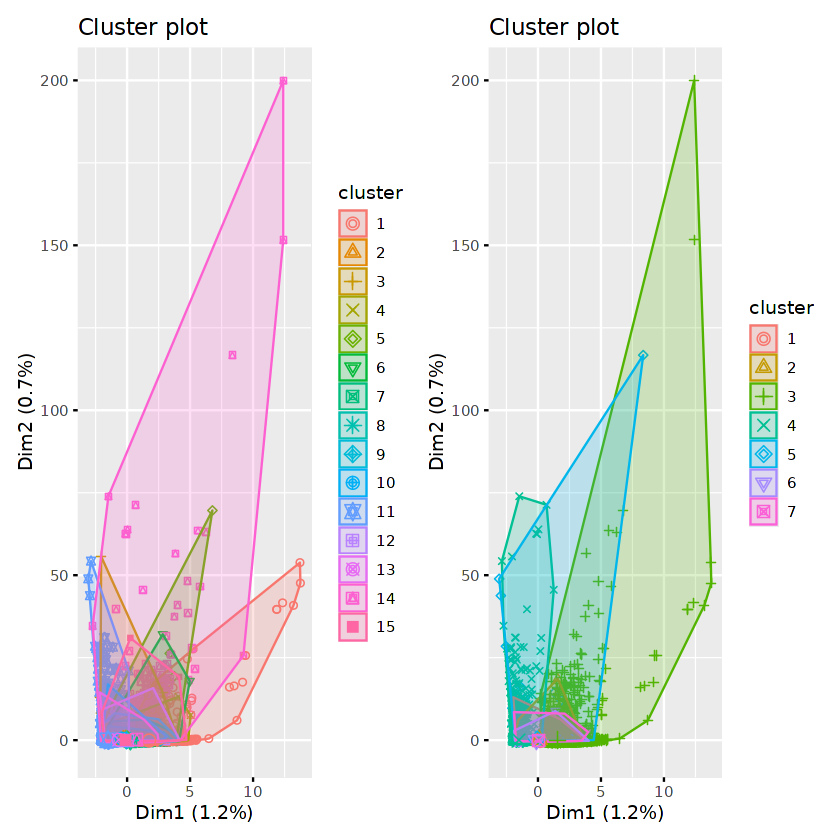

In [27]:
# Display the combined plots
combined_plots1

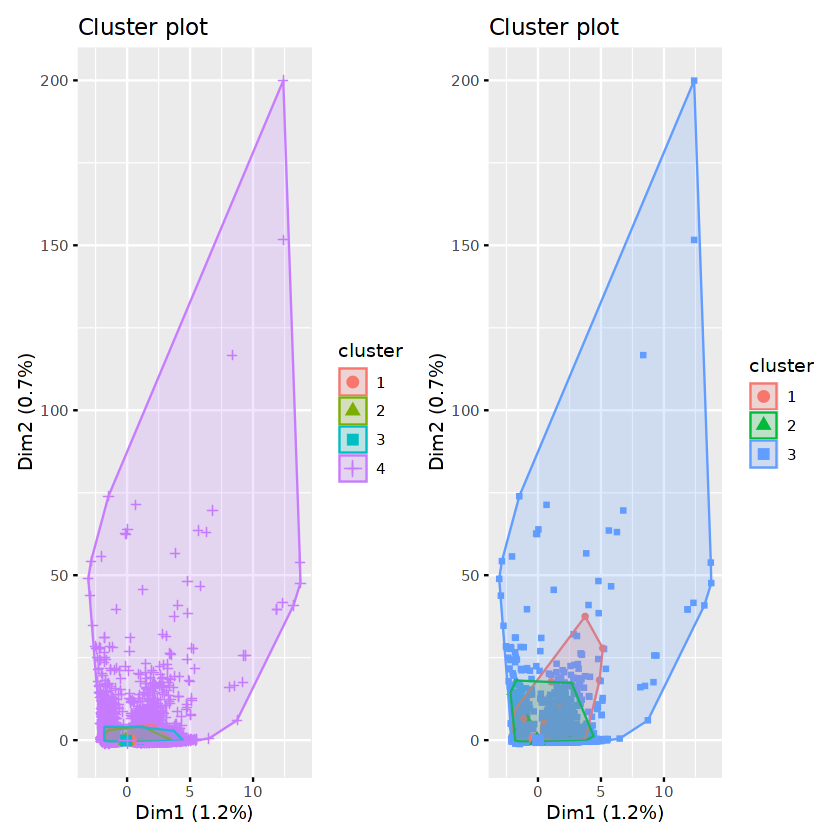

In [28]:
combined_plots2

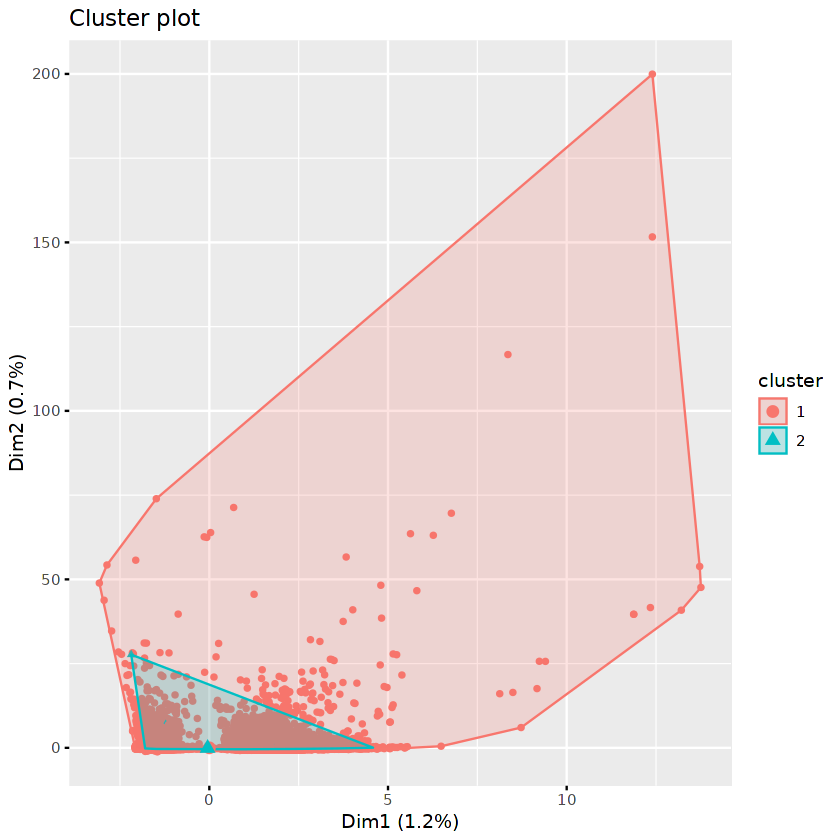

In [29]:
cluster_plot2

<h4>Print the cluster assignments</h4>

Looking at the 7 clusters 

In [30]:
centroids7 <- kmeans_model7$centers
print(centroids7)

  applicationCH applicationSV isprimaryYes KLIAlcohol Consumer
1   0.033863072  -0.033863072   0.11493910        -0.112858546
2   0.048967969  -0.048967969  -0.04070763        -0.112858546
3   1.010030910  -1.010030910   0.10319770         0.002641267
4  -0.990042381   0.990042381  -0.09992695         0.005074415
5  -0.008941736   0.008941736  -0.03305992        -0.112858546
6  -0.039611386   0.039611386  -0.05993377        -0.112858546
7   0.028486451  -0.028486451  -0.05446852        -0.112858546
  KLIAmazon Digital KLIAmazon Prime KLIAmazon.com KLIAmusement Park Patron
1      -0.042416812    -0.091293050  -0.136949296            -0.0407303257
2      -0.042416812    -0.091293050  -0.136949296            -0.0407303257
3       0.001010566     0.005473211   0.005546038             0.0004989538
4       0.001889659     0.000835211   0.003863699             0.0022764803
5      -0.042416812    -0.091293050  -0.136949296            -0.0407303257
6      -0.042416812    -0.091293050  -0.136949

The centroids show that the Customers with Savings Accounts to 2, Checkings to Cluster 3 and KLI Delivery and Takeout Restaurant Customer to Cluster 5. Number of transactions is high in cluster 3.

Walmart, Walmart members, Smoothie Drinkers, Motor sports vehicle owner, Wine drinker, Zelle Mobile payment and Zoo Patron are some variables that have the same mean in clusters 1, 2, 5, 6 and 7 meaning they have similar impact in these clusters. However these are very low mean values and therefore do not show a strong influence of these lifestyle indicators on how well the customers can be grouped. 

The other variables are spread out within the other clusters in a similar manner. 

There are enough distinct observations in the dataset. However, the number of levels in the KLI might be introducing many cluster centers. We there pick the top 10 most frequent levels in this variable.

Therefore, we explore reducing the KLI into small groups to check for more meaningfull clusters in the next section. 

<h3>Checkings Account Customers Only and Reducing the KLI indicators to top 10</h3>

Filtering the Checkings Customers

In [31]:
sampled_df_ch <- sampled_df_all %>%
    filter(application %in% c("CH"))

sampled_df_ch <- subset(sampled_df_ch, select = -c(application))

Converting the categorical variables to factors

In [32]:
# sampled_KLI$application  <- as.factor(sampled_df_ch$application)
sampled_df_ch$isprimary  <- as.factor(sampled_df_ch$isprimary)

In [41]:
KLIvar <- sampled_df_ch
KLIvar$KLI <- as.factor(KLIvar$KLI)

# Create a frequency table for the factor levels of KLI
level_counts <- table(KLIvar$KLI)

# Sort the frequency table in decreasing order
sorted_levels <- sort(level_counts, decreasing = TRUE)

# Select the top 10 levels
top_10_levels <- head(sorted_levels, 10)

# Print the top 10 levels
top_10_levels


                         Fast Food Diner 
                                    2876 
                                Employed 
                                    2581 
                    Competitive Bill Pay 
                                    2575 
              Discount Department Stores 
                                    2541 
                                 Walmart 
                                    2153 
                           Home Improver 
                                    2059 
          Deep Discount or Dollar Stores 
                                    1965 
                         Ice Cream Lover 
                                    1892 
           Home Improvement Store Patron 
                                    1877 
Delivery and Takeout Restaurant Customer 
                                    1854 

In [42]:
my_factors <- c("Fast Food Diner", "Employed", "Competitive Bill Pay", "Discount Department Stores", "Walmart", 
    "Home Improver", "Home Improvement Store Patron", "Deep Discount or Dollar Stores", 
    "Ice Cream Lover", "Delivery and Takeout Restaurant Customer")

# Use mutate to replace KLI values not in my_factors with "Other"
sampled_KLI <- sampled_df_ch %>%
    mutate(KLI = ifelse(KLI %in% my_factors, KLI, "Other")) %>%
    mutate(KLI = as.character(KLI)) %>%
    mutate(KLI = factor(KLI, levels = c(my_factors, "Other"))) # Explicitly define the levels here

# Now, sampled_KLI$KLI should not have NAs
levels(sampled_KLI$KLI)

[1] "Fast Food Diner"                         
 [2] "Employed"                                
 [3] "Competitive Bill Pay"                    
 [4] "Discount Department Stores"              
 [5] "Walmart"                                 
 [6] "Home Improver"                           
 [7] "Home Improvement Store Patron"           
 [8] "Deep Discount or Dollar Stores"          
 [9] "Ice Cream Lover"                         
[10] "Delivery and Takeout Restaurant Customer"
[11] "Other"

Replace NAs

In [43]:
sum(is.na(sampled_KLI$KLI))

[1] 0

In [44]:
str(sampled_KLI)

tibble [95,639 x 6] (S3: tbl_df/tbl/data.frame)
 $ isprimary           : Factor w/ 2 levels "No","Yes": 2 2 2 1 2 1 2 2 2 2 ...
 $ KLI                 : Factor w/ 11 levels "Fast Food Diner",..: 2 11 8 11 11 11 11 11 7 11 ...
 $ averagebalance      : num [1:95639] 5091 875 8912 125 275 ...
 $ numberoftransactions: int [1:95639] 35 37 39 33 113 16 325 79 75 26 ...
 $ baldifference       : num [1:95639] 2260 1293 8757 218 3353 ...
 $ periodamember       : num [1:95639] 17.7 14.7 16.7 15.7 10.7 ...


The KLI variable now has 11 factor levels.

Selecting the Checkings Account Customers

<h4>Elbow Method for Reduced KLIs and Checkings Customers </h4>

In [45]:
#Converting the factor variables into one hot encoding and scaling it.
df_numeric_ch <- model.matrix(~ . - 1, data = sampled_KLI)

# Standardize numeric variables
df_scaled_ch <- scale(df_numeric_ch)

In [46]:
sum(is.nan(df_scaled_ch))

[1] 0

In [47]:
head(df_scaled_ch)

,isprimaryNo,isprimaryYes,KLIEmployed,KLICompetitive Bill Pay,KLIDiscount Department Stores,KLIWalmart,KLIHome Improver,KLIHome Improvement Store Patron,KLIDeep Discount or Dollar Stores,KLIIce Cream Lover,KLIDelivery and Takeout Restaurant Customer,KLIOther,averagebalance,numberoftransactions,baldifference,periodamember
1,-0.5932268,0.5932268,6.0045516,-0.1663395,-0.1652075,-0.1517562,-0.1483318,-0.141487,-0.1448336,-0.1420626,-0.1406002,-1.8096178,-0.01117818,-0.5154431,-0.05974760,0.966122014
2,-0.5932268,0.5932268,-0.1665386,-0.1663395,-0.1652075,-0.1517562,-0.1483318,-0.141487,-0.1448336,-0.1420626,-0.1406002,0.5525971,-0.16928231,-0.4750202,-0.08398036,0.004170307
3,-0.5932268,0.5932268,-0.1665386,-0.1663395,-0.1652075,-0.1517562,-0.1483318,-0.141487,6.9044007,-0.1420626,-0.1406002,-1.8096178,0.13211904,-0.4345972,0.10304059,0.652442109
4,1.6856782,-1.6856782,-0.1665386,-0.1663395,-0.1652075,-0.1517562,-0.1483318,-0.141487,-0.1448336,-0.1420626,-0.1406002,0.5525971,-0.19741290,-0.5558660,-0.11091616,0.328306208
5,-0.5932268,0.5932268,-0.1665386,-0.1663395,-0.1652075,-0.1517562,-0.1483318,-0.141487,-0.1448336,-0.1420626,-0.1406002,0.5525971,-0.19179773,1.0610509,-0.03235027,-1.250549310
6,1.6856782,-1.6856782,-0.1665386,-0.1663395,-0.1652075,-0.1517562,-0.1483318,-0.141487,-0.1448336,-0.1420626,-0.1406002,0.5525971,-0.19994878,-0.8994608,-0.11376654,1.583025825


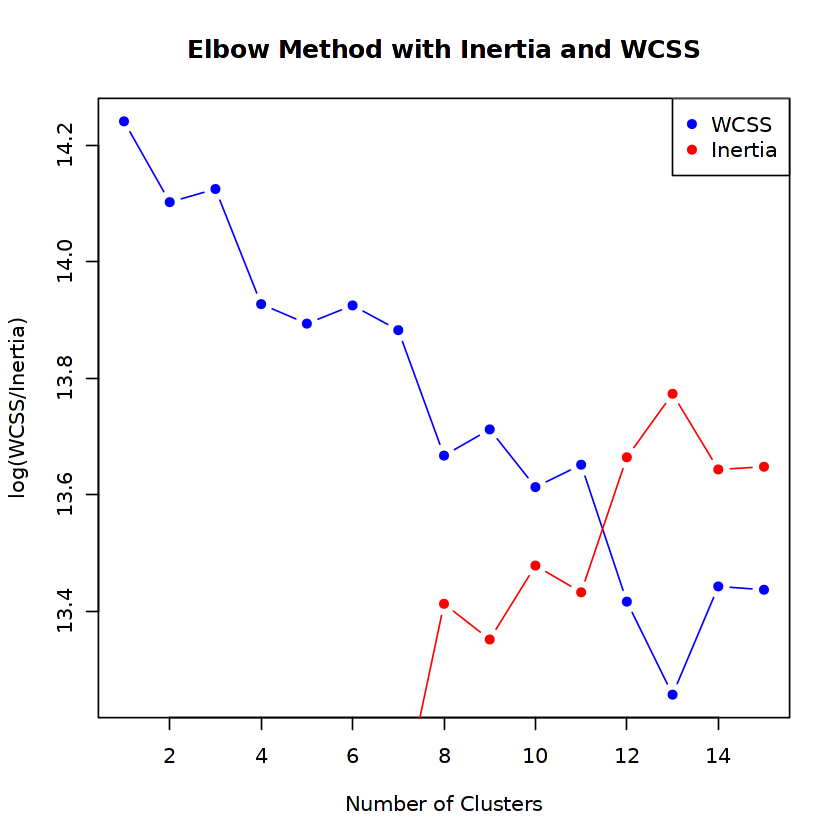

In [48]:
# Create vectors to store the within-cluster sum of squares (WCSS) and inertia for different values of k
wcss <- numeric(15)
inertia <- numeric(15)

# Define a range of values for k
k_range <- 1:15

# Iterate over each value of k
for (k in k_range) {
  # Compute K-means clustering for dataframe with variables dropped
  kmeans_model <- kmeans(df_scaled_ch, centers = k)
  
  # Store the within-cluster sum of squares (WCSS)
  wcss[k] <- kmeans_model$tot.withinss
  
  # Store the inertia
  inertia[k] <- kmeans_model$totss - kmeans_model$tot.withinss
}

# Plot the within-cluster sum of squares (WCSS) and inertia against number of clusters
plot(k_range, log(wcss), type = "b", col = "blue", pch = 16,
     xlab = "Number of Clusters", ylab = "log(WCSS/Inertia)", 
     main = "Elbow Method with Inertia and WCSS")

# Add inertia to the plot
points(k_range, log(inertia), type = "b", col = "red", pch = 16)

# Add legend
legend("topright", legend = c("WCSS", "Inertia"), col = c("blue", "red"), pch = 16)

In [49]:
# Perform k-means clustering
kmeans_model_ch11 <- kmeans(df_scaled_ch, centers = 11, nstart = 20)
kmeans_model_ch10 <- kmeans(df_scaled_ch, centers = 10, nstart = 20)
kmeans_model_ch8 <- kmeans(df_scaled_ch, centers = 8, nstart = 20)
kmeans_model_ch6 <- kmeans(df_scaled_ch, centers = 6, nstart = 20)
kmeans_model_ch4 <- kmeans(df_scaled_ch, centers = 4, nstart = 20)
kmeans_model_ch2 <- kmeans(df_scaled_ch, centers = 2, nstart = 20)

In [50]:
# Visualize the clusters using PCA
cluster_plot11 <- fviz_cluster(kmeans_model_ch11, data = df_scaled_ch, geom = "point")
cluster_plot10 <- fviz_cluster(kmeans_model_ch10, data = df_scaled_ch, geom = "point")
cluster_plot8 <- fviz_cluster(kmeans_model_ch8, data = df_scaled_ch, geom = "point")
cluster_plot6 <- fviz_cluster(kmeans_model_ch6, data = df_scaled_ch, geom = "point")
cluster_plot4 <- fviz_cluster(kmeans_model_ch4, data = df_scaled_ch, geom = "point")
cluster_plot2 <- fviz_cluster(kmeans_model_ch2, data = df_scaled_ch, geom = "point")

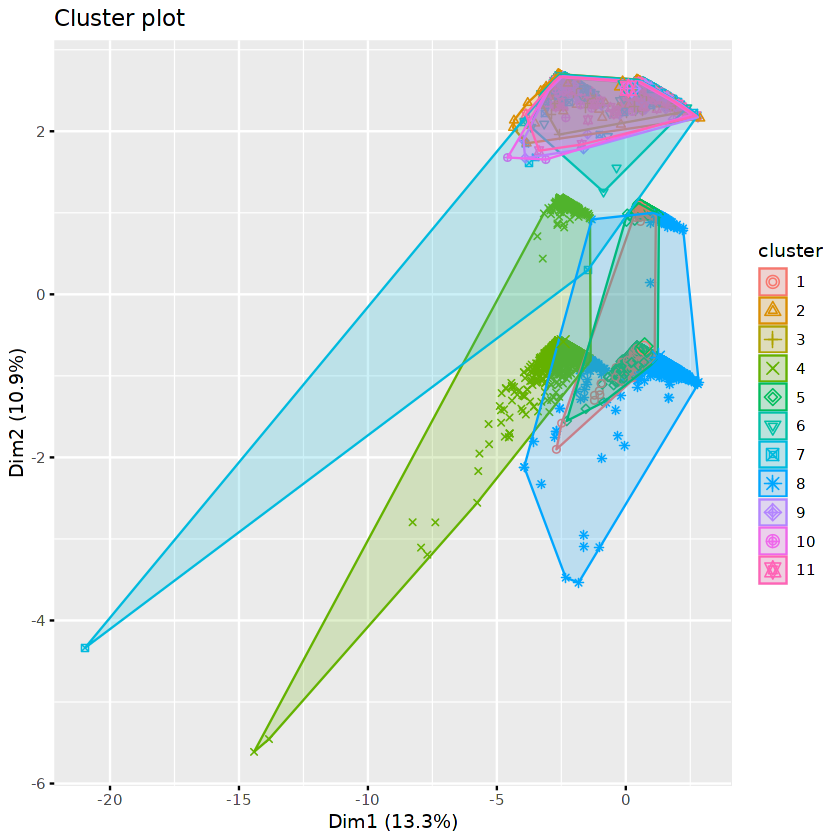

In [51]:
cluster_plot11

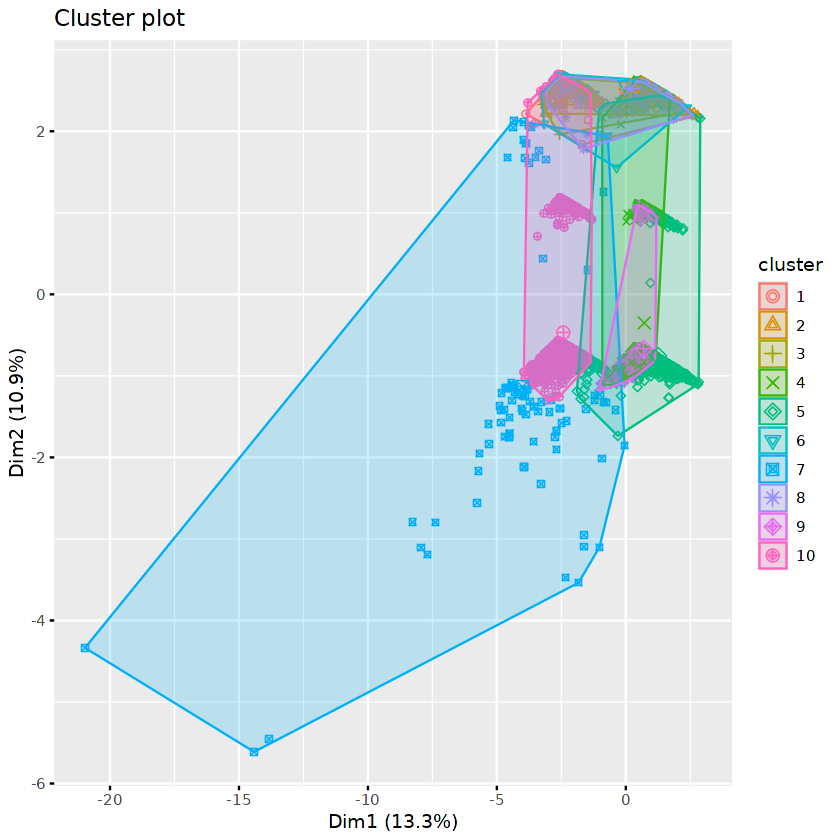

In [52]:
 cluster_plot10

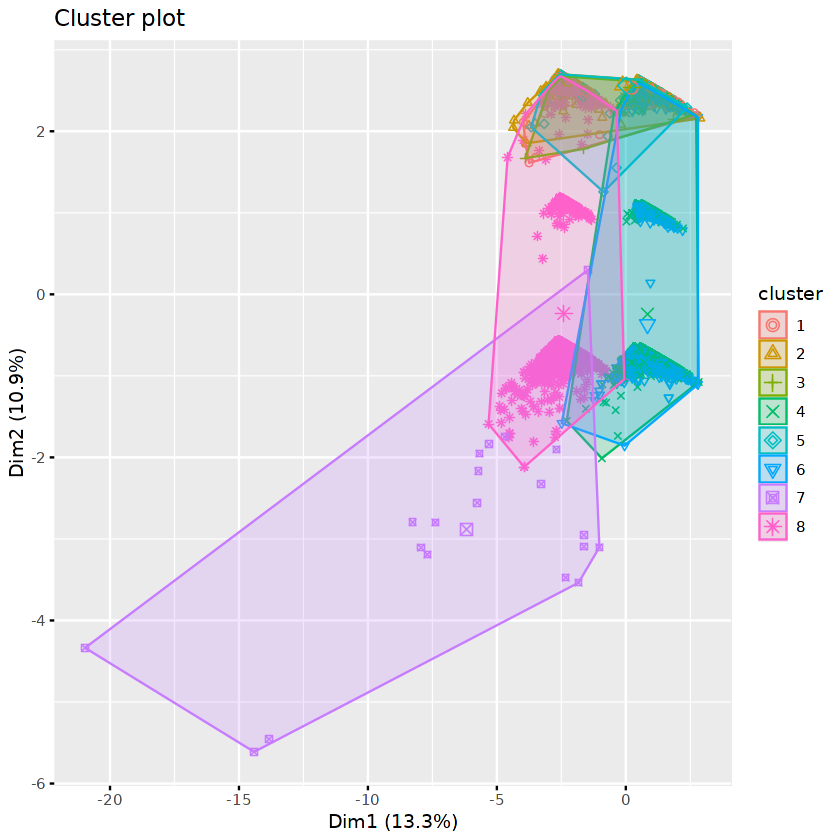

In [53]:
cluster_plot8

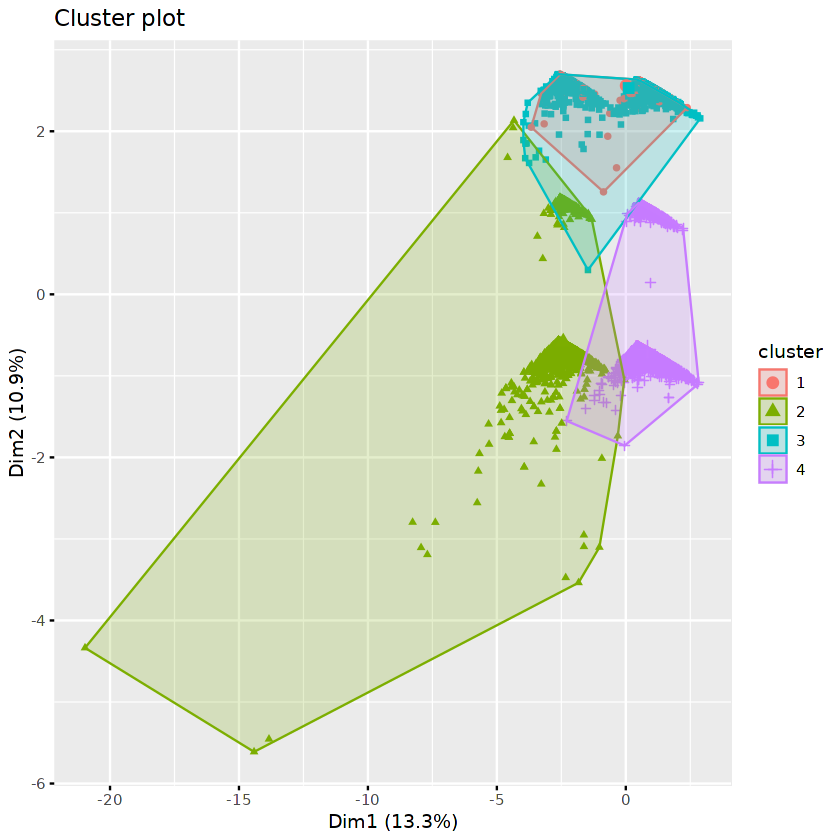

In [54]:
cluster_plot4

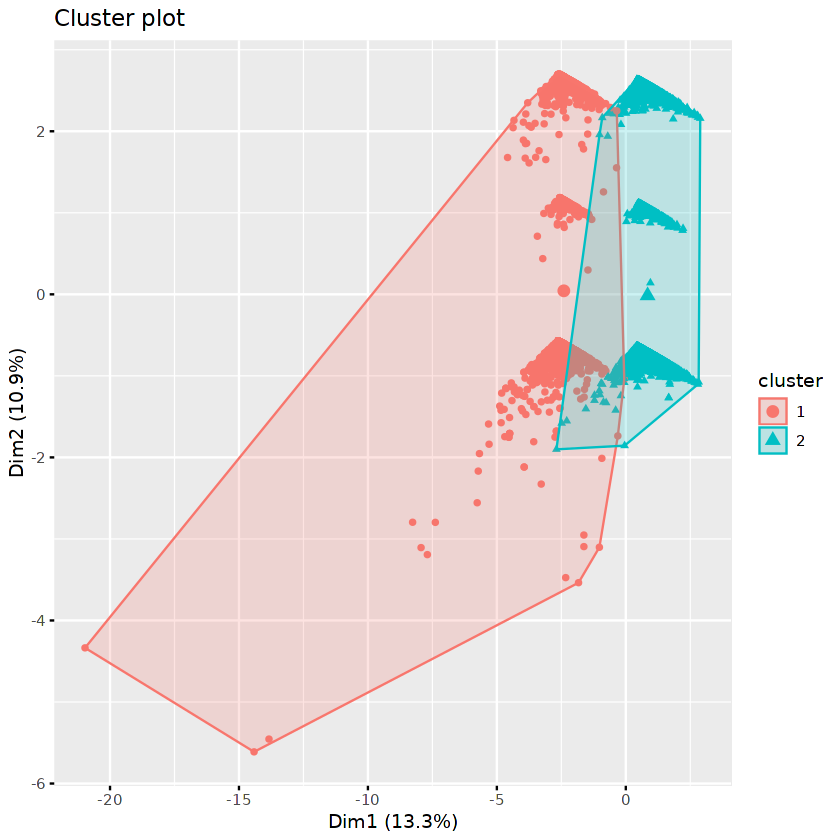

In [55]:
cluster_plot2

The 4 and 2 clusters show 6 clusters. We explore 6 clusters to see if the segmentation is distinct

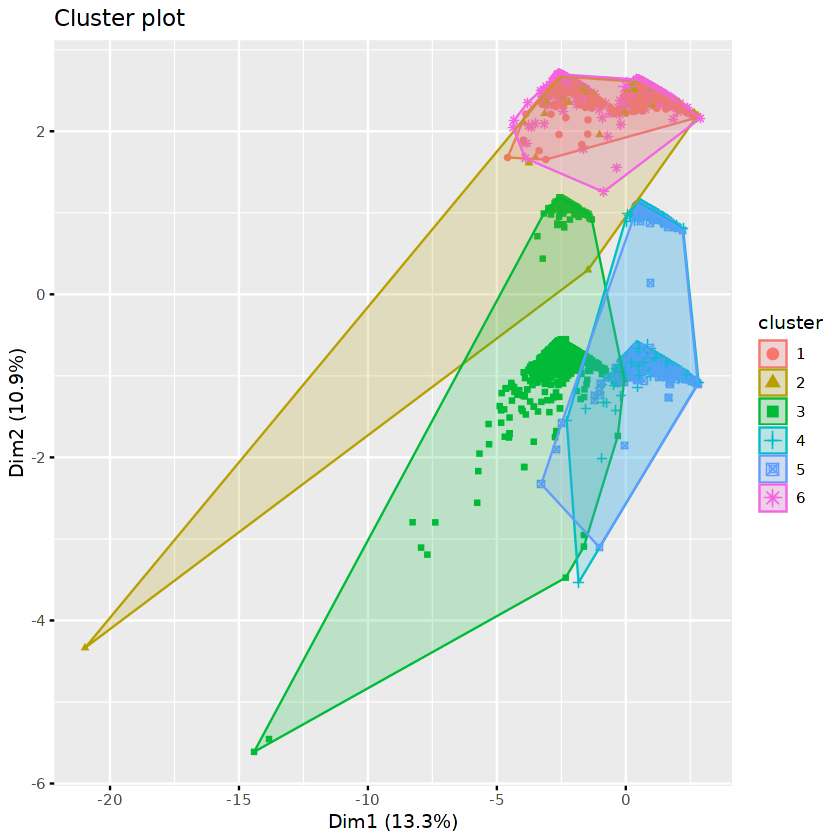

In [56]:
cluster_plot6

The clusters overlap 

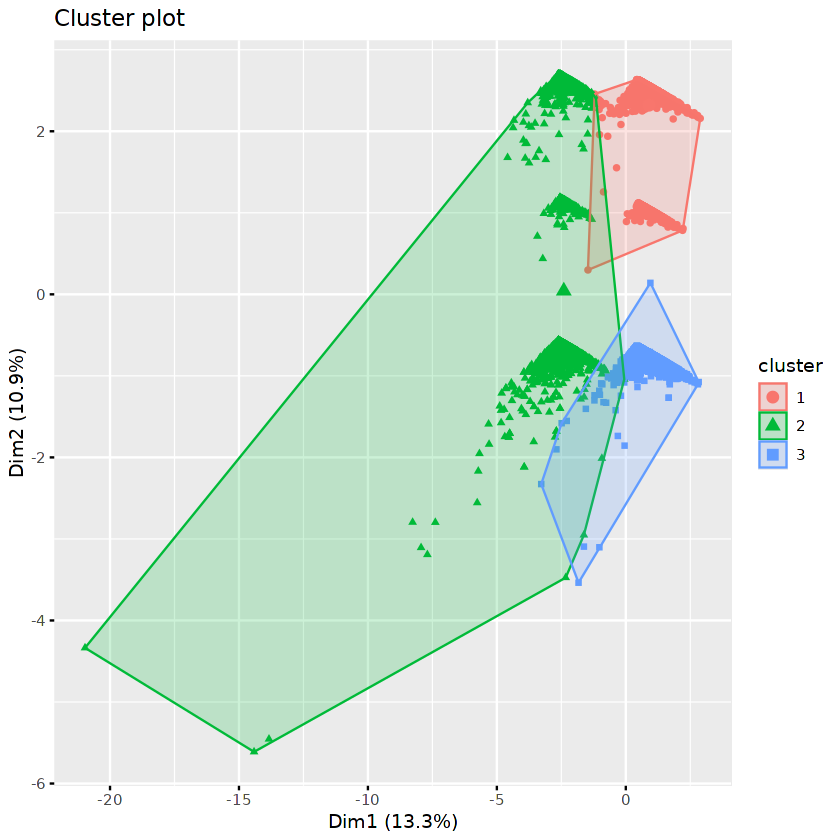

In [57]:
kmeans_model_ch3 <- kmeans(df_scaled_ch, centers = 3, nstart = 20)
cluster_plot3 <- fviz_cluster(kmeans_model_ch3, data = df_scaled_ch, geom = "point")
cluster_plot3

The customers can be segmented into 3 or 2 groups using the KLI, Checkings Account Customers, and Monthly Balance table data

<h3> Savings Customers</h3>

In [58]:
# sampled_df_sv <- sampled_KLI %>%
#     filter(application %in% c("SV"))

sampled_df_sv <- sampled_df_all %>%
    filter(application %in% c("SV"))

sampled_df_sv <- subset(sampled_df_sv, select = -c(application))

sampled_df_sv <- sampled_df_sv %>%
    mutate(KLI = ifelse(KLI %in% my_factors, KLI, "Other")) %>%
    mutate(KLI = as.character(KLI)) %>%
    mutate(KLI = factor(KLI, levels = c(my_factors, "Other"))) # Explicitly define the levels here

# Now, sampled_KLI$KLI should not have NAs
levels(sampled_df_sv$KLI)

[1] "Fast Food Diner"                         
 [2] "Employed"                                
 [3] "Competitive Bill Pay"                    
 [4] "Discount Department Stores"              
 [5] "Walmart"                                 
 [6] "Home Improver"                           
 [7] "Home Improvement Store Patron"           
 [8] "Deep Discount or Dollar Stores"          
 [9] "Ice Cream Lover"                         
[10] "Delivery and Takeout Restaurant Customer"
[11] "Other"

In [59]:
#Converting the mixed data into one hot encoding and scaling it.
df_numeric_sv <- model.matrix(~ . - 1, data = sampled_df_sv)

# Standardize numeric variables
df_scaled_sv <- scale(df_numeric_sv)

Warning message in log(inertia):
"NaNs produced"


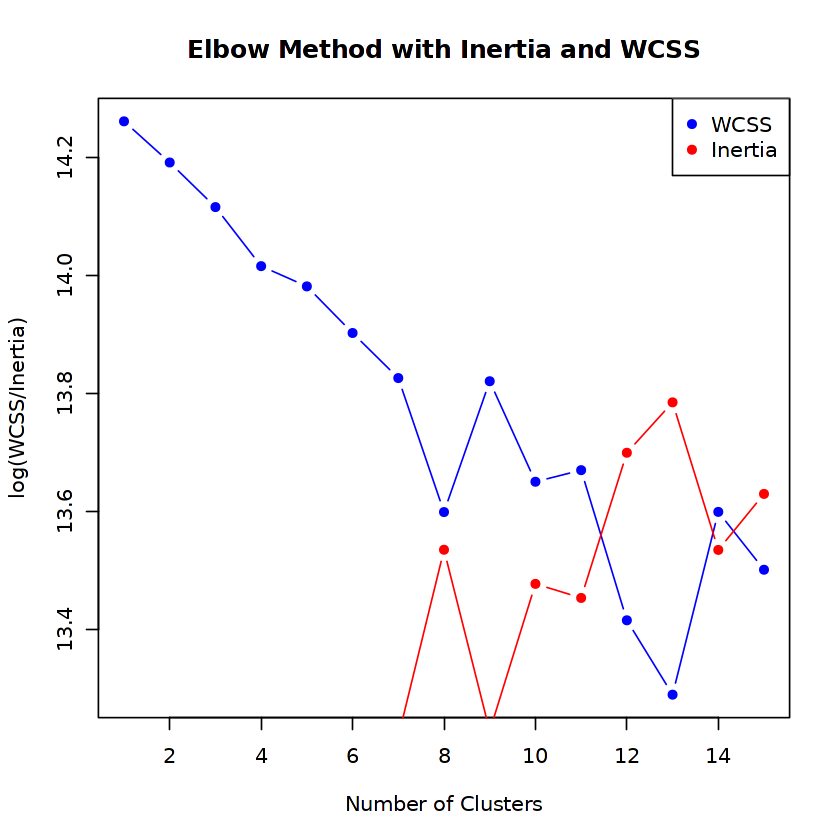

In [60]:
# Create vectors to store the within-cluster sum of squares (WCSS) and inertia for different values of k
wcss <- numeric(15)
inertia <- numeric(15)

# Define a range of values for k
k_range <- 1:15

# Iterate over each value of k
for (k in k_range) {
  # Compute K-means clustering for dataframe with variables dropped
  kmeans_model <- kmeans(df_scaled_sv, centers = k)
  
  # Store the within-cluster sum of squares (WCSS)
  wcss[k] <- kmeans_model$tot.withinss
  
  # Store the inertia
  inertia[k] <- kmeans_model$totss - kmeans_model$tot.withinss
}

# Plot the within-cluster sum of squares (WCSS) and inertia against number of clusters
plot(k_range, log(wcss), type = "b", col = "blue", pch = 16,
     xlab = "Number of Clusters", ylab = "log(WCSS/Inertia)", 
     main = "Elbow Method with Inertia and WCSS")

# Add inertia to the plot
points(k_range, log(inertia), type = "b", col = "red", pch = 16)

# Add legend
legend("topright", legend = c("WCSS", "Inertia"), col = c("blue", "red"), pch = 16)

We consider the first 3 dips in the wcss plot at 3, 8 and 12 to cluster the customers

In [61]:
# Perform k-means clustering
kmeans_model_sv12 <- kmeans(df_scaled_sv, centers = 12, nstart = 20)
kmeans_model_sv8 <- kmeans(df_scaled_sv, centers = 8, nstart = 20)
kmeans_model_sv5 <- kmeans(df_scaled_sv, centers = 5, nstart = 20)
kmeans_model_sv3 <- kmeans(df_scaled_sv, centers = 3, nstart = 20)

In [62]:
# Visualize the clusters using PCA
cluster_plot_sv12 <- fviz_cluster(kmeans_model_sv12, data = df_scaled_sv, geom = "point")
cluster_plot_sv8 <- fviz_cluster(kmeans_model_sv8, data = df_scaled_sv, geom = "point")
cluster_plot_sv5 <- fviz_cluster(kmeans_model_sv5, data = df_scaled_sv, geom = "point")
cluster_plot_sv3 <- fviz_cluster(kmeans_model_sv3, data = df_scaled_sv, geom = "point")+
      ggtitle("Visualization of 3 Clusters on Savings Account Holders")

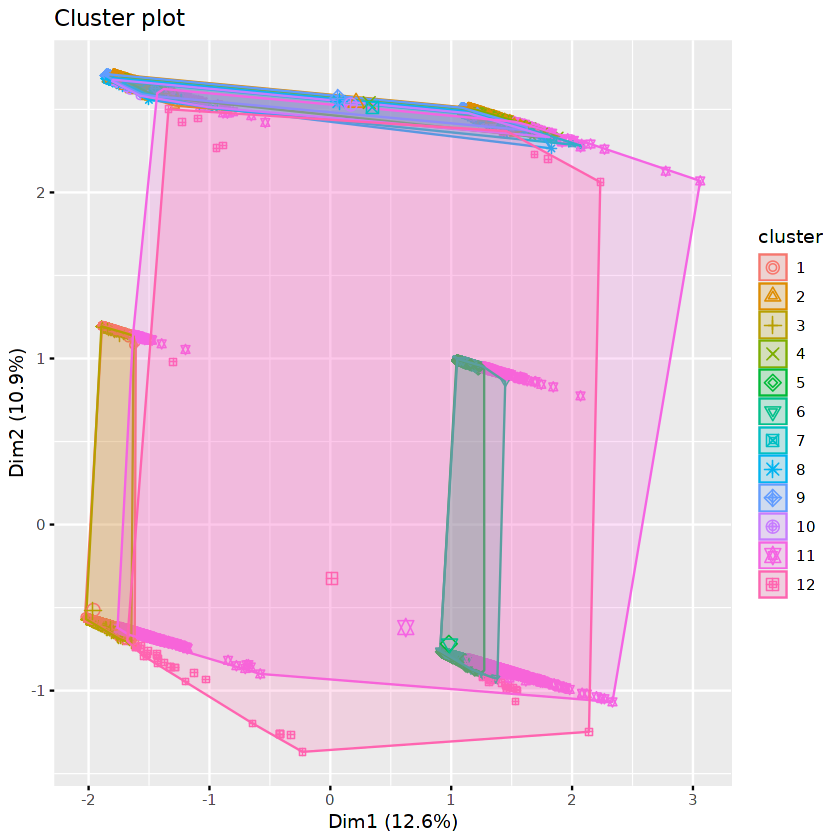

In [64]:
cluster_plot_sv12

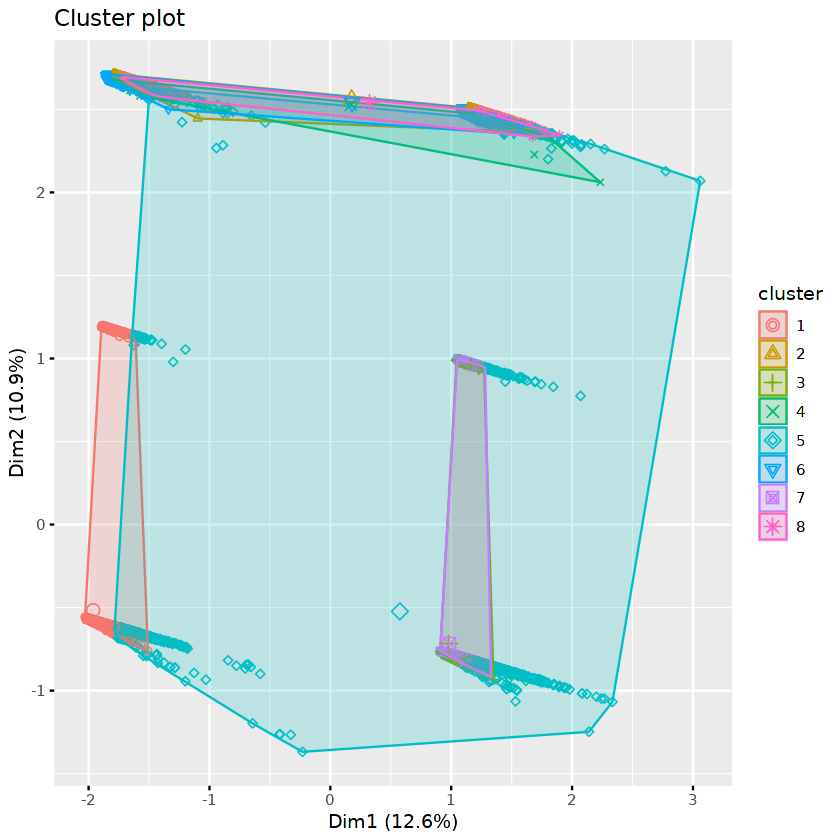

In [65]:
cluster_plot_sv8

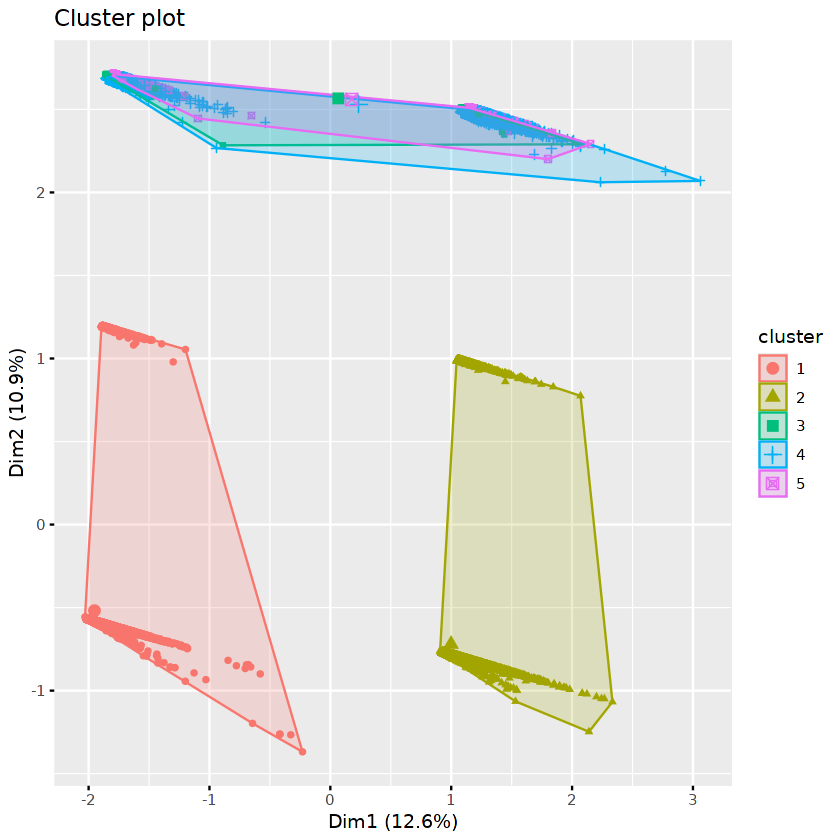

In [67]:
cluster_plot_sv5

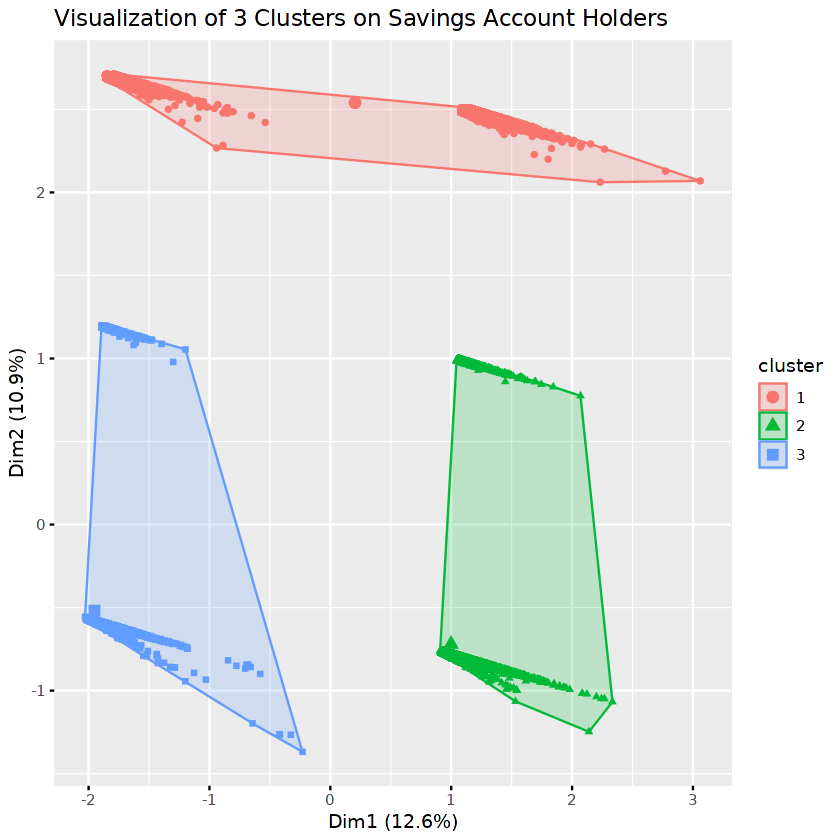

In [68]:
cluster_plot_sv3

In [69]:
centroids_sv3 <- kmeans_model_sv3$centers
print(centroids_sv3)

  isprimaryNo isprimaryYes KLIEmployed KLICompetitive Bill Pay
1 -0.01950066   0.01950066   0.6679666               0.6473563
2 -0.73990166   0.73990166  -0.1704891              -0.1652286
3  1.35151711  -1.35151711  -0.1704891              -0.1652286
  KLIDiscount Department Stores KLIWalmart KLIHome Improver
1                     0.6368936  0.5797950        0.5826223
2                    -0.1625581 -0.1479845       -0.1487061
3                    -0.1625581 -0.1479845       -0.1487061
  KLIHome Improvement Store Patron KLIDeep Discount or Dollar Stores
1                        0.5768128                         0.5632868
2                       -0.1472234                        -0.1437710
3                       -0.1472234                        -0.1437710
  KLIIce Cream Lover KLIDelivery and Takeout Restaurant Customer   KLIOther
1          0.5515357                                   0.5424180 -1.8207720
2         -0.1407717                                  -0.1384446  0.4635464
3   

<h4>Summary for Savings Customers with Reduced KLI</h4>
Using 3 clusters gives 3 distinct segments in the customer data for the Savings Account customers. To achieve this, KLI was reduced into 11 factor levels including: 'Fast Food Diner', 'Employed', 'Competitive Bill Pay','Discount Department Stores', 'Walmart''Home Improver', 'Home Improvement Store Patron', 'Deep Discount or Dollar Stores', 'Ice Cream Lover', 'Delivery and Takeout Restaurant Customer', 'Other'. This was based on the top 10 most frequent key lifestyle indicators in the dataset, and all other indicators were placed into a category called 'Other'. The following variables contribute to the 3 customer segments.

**Cluster 1:** The variables that contribute to the first segment include: Primary account holders, Employed, Competitive Bill Pay, Home Improvement Store Patron, Deep Discount or Dollar Store, Ice Cream Lover, Delivery and Takeout Restaurant Customers, as well as the difference between their maximum and minimum account balance.

**Cluster 2:** The customer that are not primary account holders, have Other KLI, the difference in their monthly account balance and their period of membership with the bank contribute to this cluster.

**Cluster 3:** The Customers that are primary account holders, and their average balance, number of transaction and those that have 'Other' as their Key Lifestyle Indicator.

<h4>Analysing the Numeric Data</h4>

In [71]:
##**** Identify numeric columns ****##
numCols <- unlist(lapply(sampled_df, is.numeric))

##**** Print Subset of Numeric Columns ****##
sampled_df_num <- sampled_df[, numCols]

In [72]:
str(sampled_df_num)

tibble [193,211 x 4] (S3: tbl_df/tbl/data.frame)
 $ averagebalance      : num [1:193211] 0.06 15.07 482.22 5090.88 874.99 ...
 $ numberoftransactions: int [1:193211] 0 1 4 35 37 39 33 3 5 113 ...
 $ baldifference       : num [1:193211] 0 0.04 220.04 2259.92 1292.78 ...
 $ periodamember       : num [1:193211] 18.77 13.73 9.67 17.73 14.67 ...


Warning message:
"did not converge in 10 iterations"
Warning message in log(inertia):
"NaNs produced"


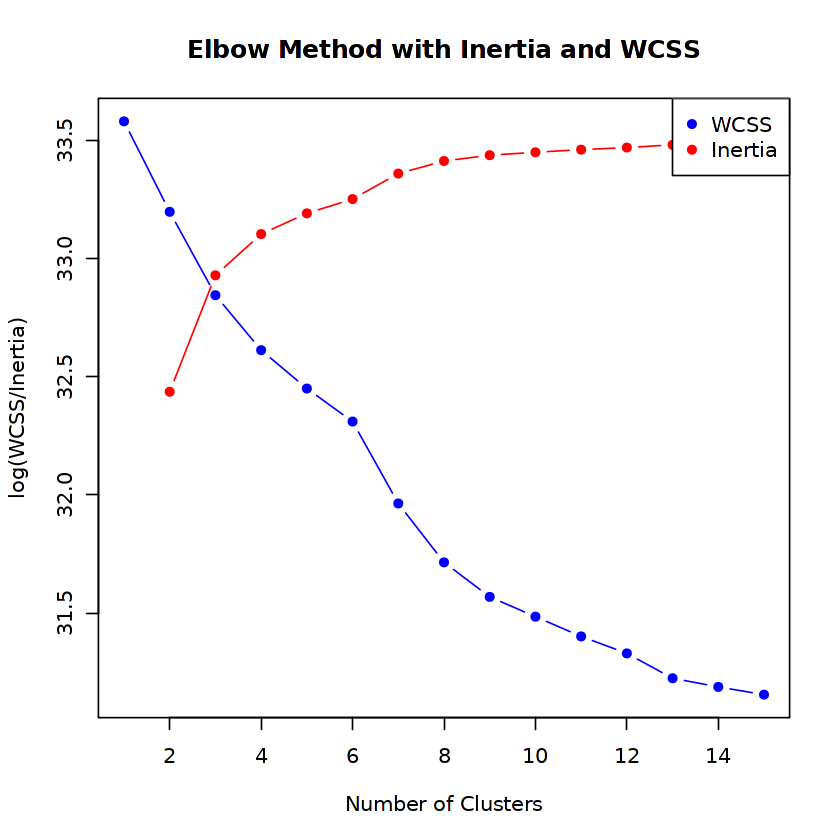

In [73]:
# Create vectors to store the within-cluster sum of squares (WCSS) and inertia for different values of k
wcss <- numeric(15)
inertia <- numeric(15)

# Define a range of values for k
k_range <- 1:15

# Iterate over each value of k
for (k in k_range) {
  # Compute K-means clustering for dataframe with variables dropped
  kmeans_model <- kmeans(sampled_df_num, centers = k)
  
  # Store the within-cluster sum of squares (WCSS)
  wcss[k] <- kmeans_model$tot.withinss
  
  # Store the inertia
  inertia[k] <- kmeans_model$totss - kmeans_model$tot.withinss
}

# Plot the within-cluster sum of squares (WCSS) and inertia against number of clusters
plot(k_range, log(wcss), type = "b", col = "blue", pch = 16,
     xlab = "Number of Clusters", ylab = "log(WCSS/Inertia)", 
     main = "Elbow Method with Inertia and WCSS")

# Add inertia to the plot
points(k_range, log(inertia), type = "b", col = "red", pch = 16)

# Add legend
legend("topright", legend = c("WCSS", "Inertia"), col = c("blue", "red"), pch = 16)

We select 5 clusters from the inertia curve

In [74]:
# Define a function to perform PCA   
perform_pca <- function(sampled_df_num) {
  # Standardize the data
  data_std <- scale(sampled_df_num)
  
  # Perform PCA
  pca_result <- prcomp(data_std, scale. = TRUE)
  # Return PCA results
  return(pca_result)
}
pca_res <- perform_pca(sampled_df_num)

Applying PCA for feature reduction since the variables are now many. Using a scree plot, we can decide how many principal components would maintain 80% of the variance in the data.

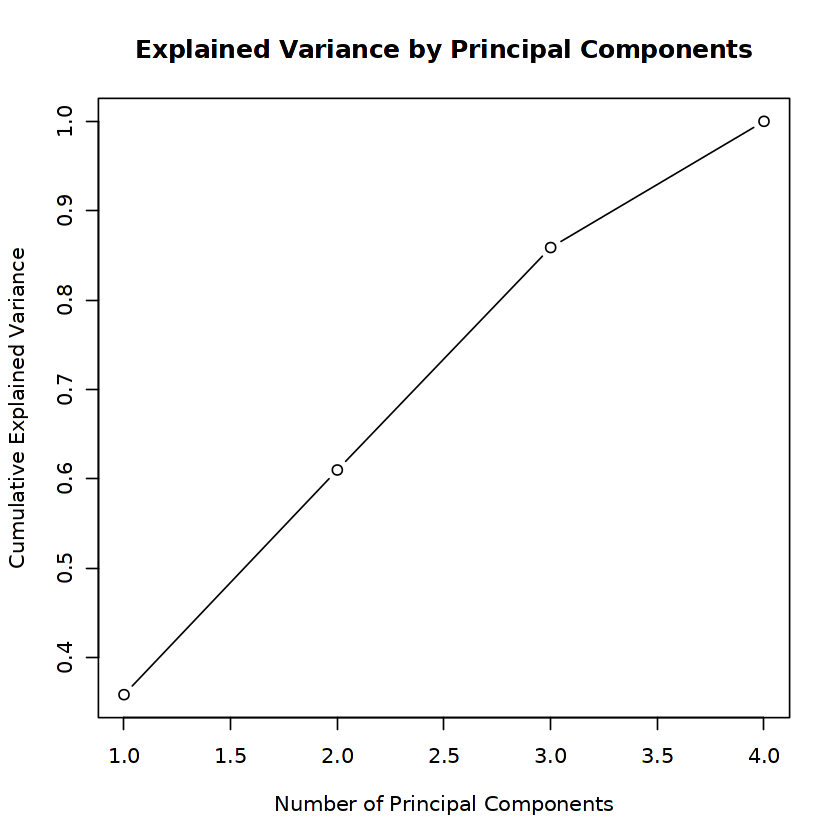

In [75]:
# Define a function to visualize explained variance
visualize_explained_variance <- function(pca_res) {
  # Plot cumulative explained variance
  plot(cumsum(pca_res$sdev^2 / sum(pca_res$sdev^2)), 
       type = "b", xlab = "Number of Principal Components", 
       ylab = "Cumulative Explained Variance", 
       main = "Explained Variance by Principal Components")
}

# Visualize explained variance for each dataframe

visualize_explained_variance(pca_res)

The scree plot shows that 3 PCs explain 86% of the variance in the data. We can therefore consider to retain only 3 Principal components

Warning message:
"did not converge in 10 iterations"


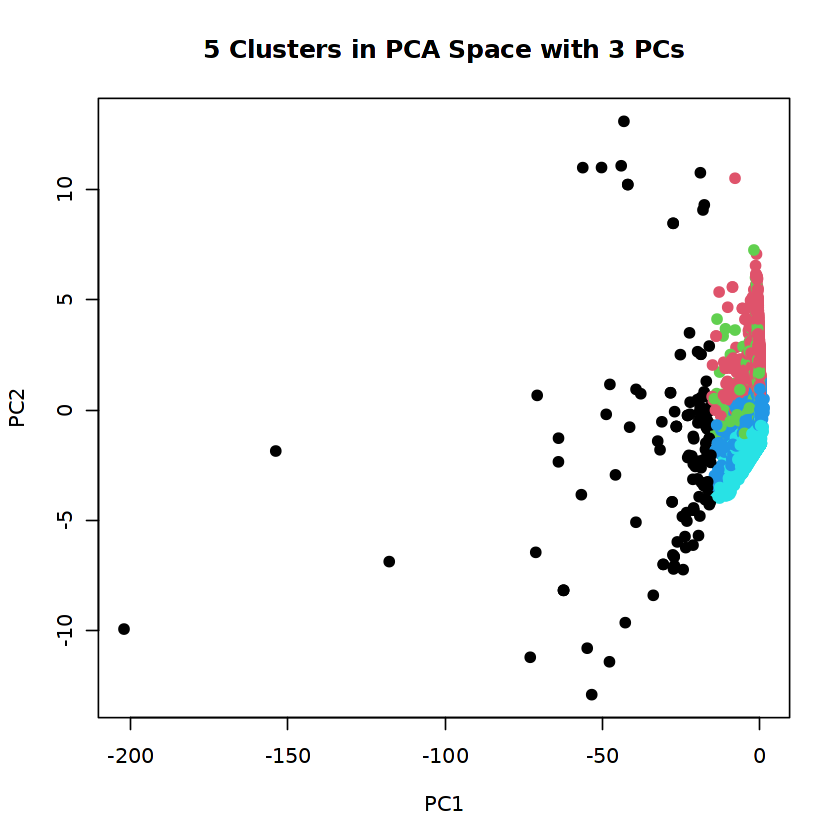

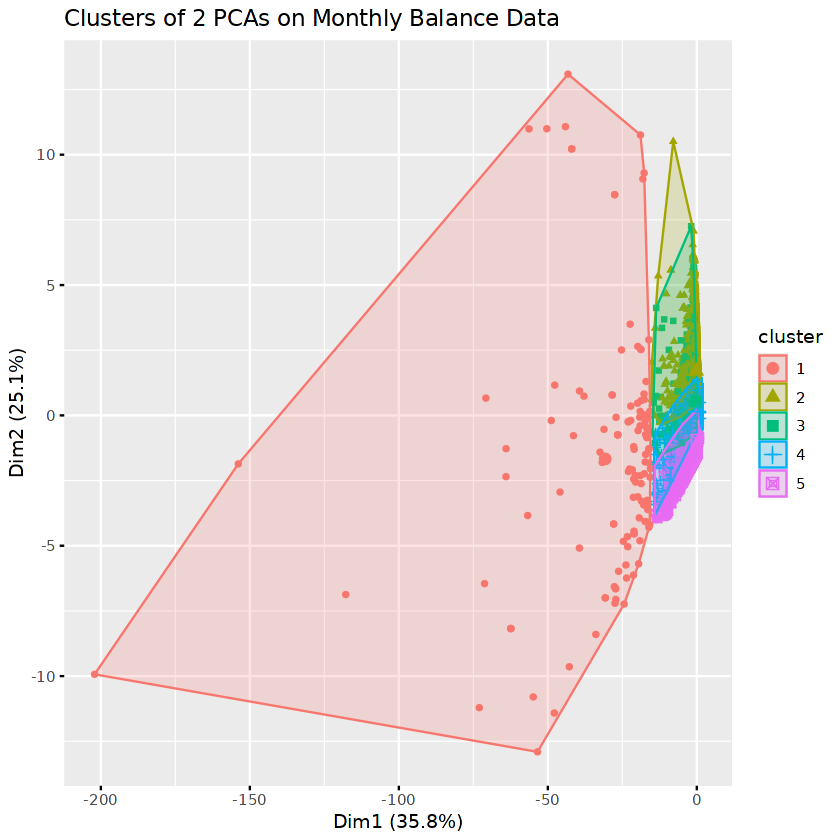

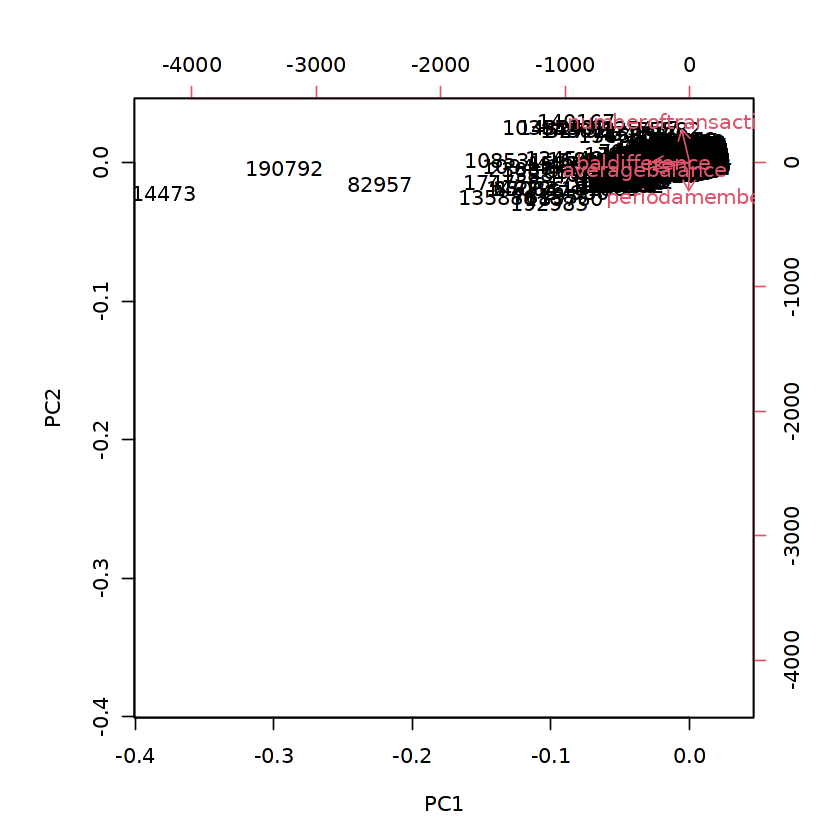

In [76]:
#Cluster the data on the PC scores
k <- 5
kmeans_res <- kmeans(pca_res$x[, 1:3], centers = k, nstart = 20)

clusters <- kmeans_res$cluster

# Plotting the clusters in the reduced-dimensional space from PCA
plot(pca_res$x[, 1:3], col = clusters, pch = 19, main = "5 Clusters in PCA Space with 3 PCs")

fviz_cluster(kmeans_res, data = sampled_df_num, geom = "point") +
      ggtitle("Clusters of 2 PCAs on Monthly Balance Data")

biplot(pca_res)

With the numeric variables, we get more distinct clusters. However, since there is an overlap in the 3rd and 5th cluster, we consider 3 clusters with 2 principal components as discussed in the next section

Consider 2 Principal Components and 3 Clusters

<h4>Considering 3 Clusters and 2 PCs</h4>

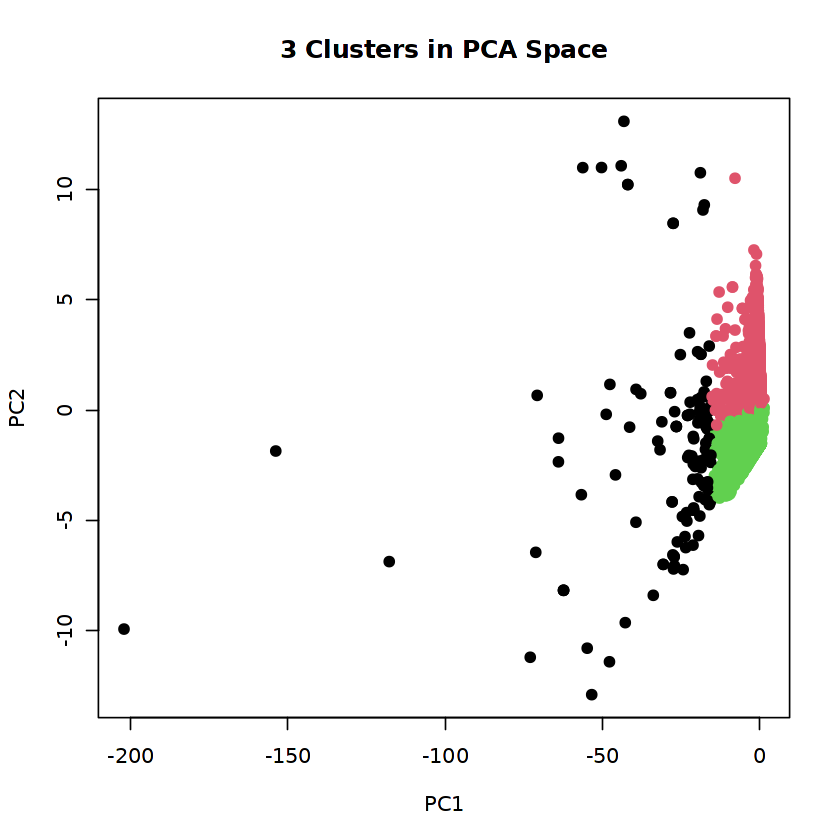

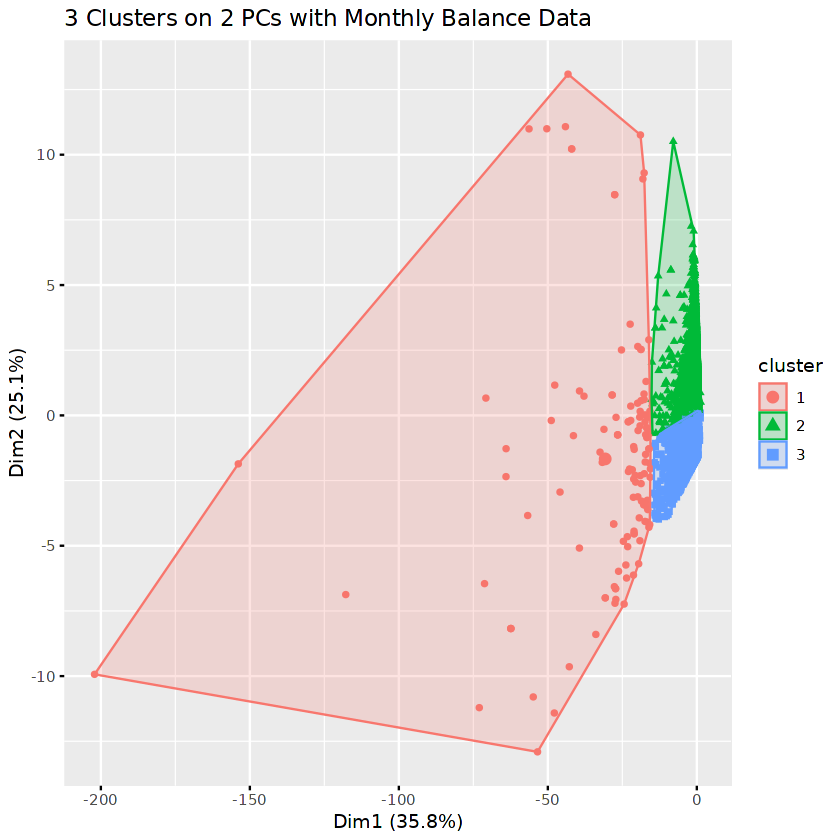

In [77]:
kmeans_res3 <- kmeans(pca_res$x[, 1:2], centers = 3, nstart = 20)

clusters <- kmeans_res3$cluster

# Plotting the clusters in the reduced-dimensional space from PCA
plot(pca_res$x[, 1:2], col = clusters, pch = 19, main = "3 Clusters in PCA Space")

fviz_cluster(kmeans_res3, data = sampled_df_num, geom = "point") +
      ggtitle("3 Clusters on 2 PCs with Monthly Balance Data")

In [78]:
pca_res$rotation

,PC1,PC2,PC3,PC4
averagebalance,-0.69068226,-0.15976210,-0.14823529,0.6895363531
numberoftransactions,-0.14801193,0.75003322,0.62451090,0.1597772431
baldifference,-0.70767305,0.01337242,-0.00305209,-0.7064069095
periodamember,-0.01579041,-0.64167548,0.76681361,0.0003585882


PCA shows that all four variables have a low impact on PC1, while the Number of transactions and balance a customer maintains in a given month contribute highly to PC2. 

Both the period of membership and number of transactions contribute highly to PC3. 
The balance variable has a low significance in PC4.

In [79]:
centroids <- kmeans_res$centers
print(centroids)

           PC1        PC2        PC3
1 -30.74651597 -1.6690573 -1.8561385
2  -0.20412090  1.7018195  0.3944651
3  -0.22607890  0.5350844  1.7103331
4   0.10269978  0.1520414 -0.8784111
5   0.07210451 -0.9638073  0.4514076


<h4>Summary of PCA Analysis on Monthly Balance Data</h4>

The PCA Analysis shows that we can use 2 principal components with the number of transactions, period of membership and average monthly balance for segmentation of the customers into 3 groups.

<h1>Conclusions</h1>


This work has analysed segmentation of the 3RFCU customers using the customer to account table, monthly balance data, and the Key Lifestyle Indicator. The following insights were gained for the analysis.

1. The **KLI and monthly transaction data** for both **Savings and Checkings** customers did not produce any meaningful customer segments. Therefore, the savings and checkings accounts were considered seperately.

2. Segmenting **Savings Account customers** into three distinct groups was achieved by categorizing the 'Key Lifestyle Indicators' (KLIs) variable into 11 factor levels. The top 10 most frequent KLIs in the dataset were identified, while all other indicators were grouped into a category labeled 'Other.' Utilizing this refined categorical variable, as well as the Monthly Balance data, we identified 3 customer segments. These customer segments are delineated by the frequency of transactions on an account, the membership period, and the monthly account balances maintained. The following variables contribute to each of the 3 customer segments.
    
    **Cluster 1:** The variables that contribute to the first segment include: Primary account holders, Employed, Competitive Bill Pay, Home Improvement Store Patron, Deep Discount or Dollar Store, Ice Cream Lover, Delivery and Takeout Restaurant Customers, as well as the difference between their maximum and minimum account balance.

    **Cluster 2:** The customer that are not primary account holders, have Other KLI, the difference in their monthly account balance and their period of membership with the bank contribute to this cluster.

    **Cluster 3:** The Customers that are primary account holders, and their average balance, number of transaction and those that have 'Other' as their Key Lifestyle Indicator.
    
    These segments show unique characteristics and diverse needs of Savings Account holders that can be harnessed to achieve personalised customer experience.

3. The **Checkings Customers**, their **KLIs** and monthly transactions resulted in **2-3** overlapping **segments**. Their features were similar across the different segments and could not be distinguished clustered. 

4. From the **monthly balance data**, the averagebalance, transaction frequency,  membership period, and the balance maintained each month, the customers were segmented into 3 distinct groups. The data was reduced into 3 Principal components using PCA. The final segmentation was based on 2 Principal components since they explained about 62% of the variance in the data. The number of transactions, period of membership and average monthly balance contributed to segmenting the customers into these 3 groups.

5. Some key takeaways: using a high value for the nstart argument while running the kmeans() clustering provided better results since the kmeans clustering was performed with multiple random assignments. It results in a desirable local optimum. Additionally, using the within-cluster sum of squares showed that the data was complex and clusters selection was subjective. Further, reducing the data to about 200,000 observations improved the performance of the server.